In [1]:
!pip3 install audiosegment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 2.4 MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp38-cp38-linux_x86_64.whl size=71519 sha256=ef429aedf33e25c8bfcf7f1b53ebec93b6bbbe754354d21e492832bf8342791b
  Stored in directory: /root/.cache/pip/wheels/75/e1/fc/01099a9fd0882ce84cc99eb51495812bb8a703461c2b0ca1cb
Successfully built webrtcvad


### загружаем данные

In [4]:
# через диск
from google.colab import drive
drive.mount('/content/drive')
import shutil
shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/AudioClassfication.zip', '/content')
shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/dataset_splitted.zip', '/content/dataset_splitted')

Mounted at /content/drive


In [2]:
# через гит
!git clone https://github.com/Mihailovskaya/AudioClassification

Cloning into 'AudioClassification'...
remote: Enumerating objects: 3552, done.
remote: Total 3552 (delta 0), reused 0 (delta 0), pack-reused 3552
Receiving objects: 100% (3552/3552), 708.08 MiB | 30.76 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (3520/3520), done.


In [4]:
import sys 
from torch.utils.data import DataLoader
import numpy as np
import torch 
import time
import torch.nn.functional as F
import os
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

sys.path.insert(0,'/content/AudioClassification/')
from utils.audio_dataset import AudioDataset as SoundDataset
from utils.helper_funcs import collate_fn, add_weight_decay
from modules.soundnet import SoundNetRaw as SoundNet

# create DataLoader

In [4]:
data_path = '/content/dataset_splitted'
n_classes = 10
sampling_rate = 22050
batch_size = 8
segment_length = 114688 #88200

train_set = SoundDataset(
    data_path,
    mode='train',
    segment_length=segment_length,
    sampling_rate=sampling_rate
)
val_set = SoundDataset(
    data_path,
    mode='val',
    segment_length=segment_length,
    sampling_rate=sampling_rate
)

train_loader = DataLoader(
    train_set, 
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    collate_fn=collate_fn
)

In [4]:
#for iterno, (x, y) in enumerate(train_loader):
  #print(y)
  #break

# create model 

In [ ]:
nf = 16
ds_fac = 1024
n_classes = 10
net = SoundNet(nf=nf,
               clip_length=segment_length // ds_fac,
               n_classes=n_classes
               )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

In [6]:
# распад веса
#wd=1e-5
#filter_bias_and_bn = True

loss_type = "label_smooth"
max_lr = 3e-4

# в шагах батча
log_interval = 60
save_interval = 60

run_name = '1'
n_epochs = 20

в f'content/result/{run_name}' сохраняется:
*   лучшая сеть 
*   costs.txt - записи о train  датасете f'{steps}-{acc}-{loss}'
*   costs_test.txt - записи о val датасете f'{steps}-{acc}-{loss}'




In [7]:
from train import train_net, inference
train_net(net, train_loader, val_loader, run_name = '1', n_epochs = 20, log_interval = 60, save_interval = 60, loss_type='label_smooth', load_root=None)


0.125 interval: 60
epoch 1/20 | iters 0/305 | acc: 0.00 | loss: 0.04 | ms/batch 57.22 
0.1 saved
test: Epoch 1 | Iters 0 | acc: 0.1000 loss: 2.52 | ms/batch 51.91 
----------------------------------------------------------------------------------------------------
21.375 interval: 60
epoch 1/20 | iters 60/305 | acc: 0.36 | loss: 1.97 | ms/batch  2.17 
0.18846153846153846 saved
test: Epoch 1 | Iters 60 | acc: 0.1885 loss: 2.38 | ms/batch 51.89 
----------------------------------------------------------------------------------------------------
27.5 interval: 60
epoch 1/20 | iters 120/305 | acc: 0.46 | loss: 1.61 | ms/batch  1.74 
0.5711538461538461 saved
test: Epoch 1 | Iters 120 | acc: 0.5712 loss: 1.43 | ms/batch 41.51 
----------------------------------------------------------------------------------------------------
29.625 interval: 60
epoch 1/20 | iters 180/305 | acc: 0.49 | loss: 1.49 | ms/batch  1.77 
test: Epoch 1 | Iters 180 | acc: 0.5154 loss: 1.41 | ms/batch 40.39 
---------

# графики

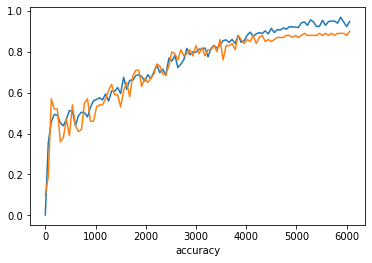

In [4]:
import matplotlib.pyplot as plt
y = []
acc = []
run_name =1
with open(f'result/{run_name}/costs.txt') as file:
  for line in file:
        l = line.split('-')
        y.append(float(l[0]))
        acc.append(float(l[1]))
y_test = []
acc_test = []
with open(f'result/{run_name}/costs_test.txt') as file:
  for line in file:
        l = line.split('-')
        y_test.append(round(float(l[0]),2))
        acc_test.append(round(float(l[1]),2))


fig, ax = plt.subplots()
plt.xlabel('accuracy')

ax.plot(y, acc)
ax.plot(y_test, acc_test)

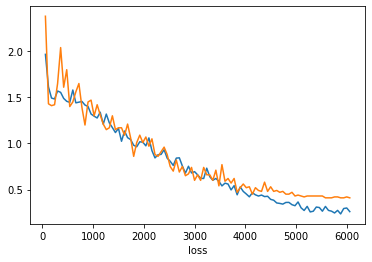

In [8]:
y = []
acc = []
with open(f'result/{run_name}/costs.txt') as file:
  for line in file:
        l = line.split('-')
        y.append(float(l[0]))
        acc.append(float(l[2]))
y_test = []
acc_test = []
with open(f'result/{run_name}/costs_test.txt') as file:
  for line in file:
        l = line.split('-')
        y_test.append(round(float(l[0]),2))
        acc_test.append(round(float(l[2]),2))


fig, ax = plt.subplots()
plt.xlabel('loss')

ax.plot(y[1:], acc[1:])
ax.plot(y_test[1:], acc_test[1:])

# inferance 1 audio

In [ ]:
from train import train_net, inference
path_sound = '/content/dataset_splitted/test/0/177621-0-0-120.wav'
path_net = '/content/result/1/net.pkl'
inference(path_sound, path_net)

# infer dataset

In [1]:
import sys 
import torch
sys.path.insert(0,'/content/AudioClassification/')

from utils.audio_dataset import AudioDataset as SoundDataset
from torch.utils.data import DataLoader

data_set = SoundDataset('/content/dataset_splitted',
                                mode='test',
                                segment_length=114688,
                                sampling_rate=22050)
data_loader = DataLoader(data_set,
                             batch_size=128,
                             pin_memory=True if torch.cuda.is_available() else False,
                             shuffle=False)

0/5
1/5
2/5
3/5
4/5
Confusion matrix, without normalization
                  precision    recall  f1-score   support

 air_conditioner       0.88      0.94      0.91        54
        car_horn       0.85      0.94      0.89        54
children_playing       0.91      0.74      0.82        54
        dog_bark       0.90      0.81      0.85        54
        drilling       0.98      0.91      0.94        54
   engine_idling       0.90      0.98      0.94        54
        gun_shot       1.00      0.98      0.99        54
      jackhammer       0.93      0.96      0.95        54
           siren       0.80      0.91      0.85        54
    street_music       0.88      0.81      0.85        54

        accuracy                           0.90       540
       macro avg       0.90      0.90      0.90       540
    weighted avg       0.90      0.90      0.90       540

conf matrix: 
tensor([[51,  0,  0,  0,  0,  1,  0,  1,  1,  0],
        [ 0, 51,  1,  2,  0,  0,  0,  0,  0,  0],
        [ 0

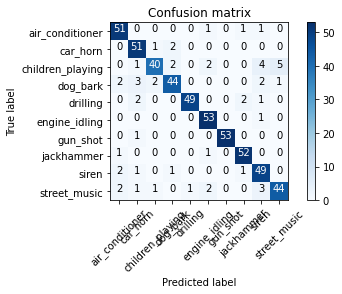

In [3]:
from train import test 
path_net = '/content/result/1/net.pkl'
test(path_net, data_loader)